In [18]:
using Pkg
Pkg.activate(".")
Pkg.instantiate();

 Activating environment at `C:\AlpOkul\TUe_Masters\Internship_BIASLab\CVI_AlpSemih\Project.toml`


In [19]:
using Random,LinearAlgebra, Flux.Optimise, Plots, ForneyLab
using ForneyLab:iBLR,KL_bc
using ColorSchemes
;

In [20]:
Random.seed!(1235);

# Generate Measurement

In [21]:
# Data and the Underlying Function
true_value = 120.0
f(x)=(x^3)*exp(-0.005*abs(x))*-1
y_obs=f(true_value)+randn();

N=10 # number of experiments

println("Measurement = $y_obs")

Measurement = -948346.6163545972


# Free Energy Surface Plot

In [22]:
s_out = 1e4
μ_out = f(120)
msg_out = Message(Univariate, GaussianWeightedMeanPrecision,xi=s_out*μ_out,w=s_out)
sample(μ,S) = μ+sqrt(S)*randn()

λ_prior=[0,0.01]
FE(μ,S) = KL_bc([μ,S],λ_prior,msg_out.dist)-mean([logPdf(msg_out.dist,f.(sample(μ,S))) for x in 1:100]);

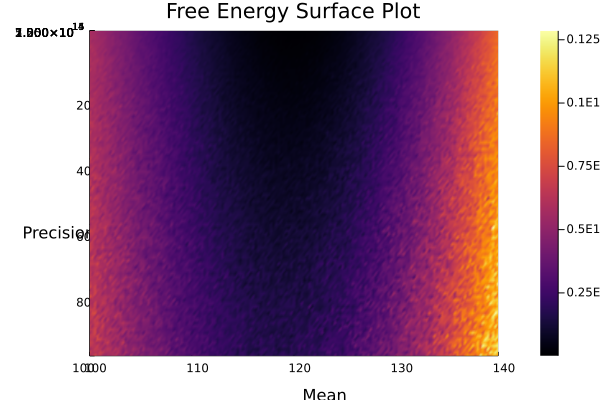

In [23]:
μ_arr = 100:0.25:140
S_arr = 1:1:100
FE_surf = zeros(size(μ_arr)[1],size(S_arr)[1])
for i in 1:size(μ_arr)[1],j in 1:size(S_arr)[1]
    FE_surf[i,j] = FE(μ_arr[i],S_arr[j])
end
plot(S_arr,μ_arr,FE_surf,st=:surface,camera=(90,90))
xlabel!("Precision")
ylabel!("Mean")
title!("Free Energy Surface Plot")

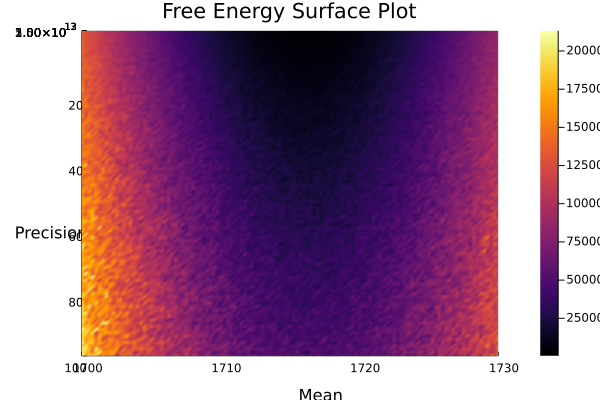

In [24]:
μ_arr = 1700:0.25:1730
S_arr = 1:1:100
FE_surf = zeros(size(μ_arr)[1],size(S_arr)[1])
for i in 1:size(μ_arr)[1],j in 1:size(S_arr)[1]
    FE_surf[i,j] = FE(μ_arr[i],S_arr[j])
end
plot(S_arr,μ_arr,FE_surf,st=:surface,camera=(90,90))
xlabel!("Precision")
ylabel!("Mean")
title!("Free Energy Surface Plot")

In [25]:
function plot_result(posterior_means,diagnostic_scores)
    N = length(posterior_means)
    success = []
    fails = []
    for (idx,mean,score) in zip(1:N,posterior_means,diagnostic_scores)
        isnan(score) ? push!(fails,[idx,mean,score]) : push!(success,[idx,mean,score])
    end
    success_x = [success[j][1] for j in 1:length(success)]
    success_y = [success[j][2] for j in 1:length(success)]
    success_z = [success[j][3] for j in 1:length(success)]
    fails_x = [fails[j][1] for j in 1:length(fails)]
    fails_y = [fails[j][2] for j in 1:length(fails)]
    fails_z = [fails[j][3] for j in 1:length(fails)]
    
    
    # Plotting
    c1 = get(ColorSchemes.rainbow,0.5)
    c2 = get(ColorSchemes.rainbow,1)
    scatter(success_x,success_y,markershape=:star5,label="FiniteScore",color=c1)
    xlabel!("Iteration index")
    ylabel!("Posterior mean estimate of q(z)")
    hline!([120],label="μ=120",linestyle=:dash)
    display(scatter!(fails_x,fails_y,markershape=:xcross,label="NaNScore",color=c2,legend=:outertopright))
end
;

In [26]:
all_data = Dict(:algo=>[],:idx=>[],:mean=>[],:score=>[])
idx_counter = 1
function insert_data!(all_data,algo,idx,mean,score)
    push!(all_data[:algo],algo)
    push!(all_data[:idx],idx)
    push!(all_data[:mean],mean)
    push!(all_data[:score],score)
end
#0 : Sampling
#1 : Descent
#2 : ADAM
#3 : iBLR
;

# Sampling

In [27]:
# g=FactorGraph()
# @RV z ~ GaussianMeanVariance(0.0, 100.0)
# @RV x ~ Nonlinear{Sampling}(z, g=f, n_samples=10000)
# @RV y ~ GaussianMeanVariance(x, 100.0)
# placeholder(y, :y)
# # Infer algorithm
# pfz = PosteriorFactorization(g)
# algo = messagePassingAlgorithm([z, x])
# source_code = algorithmSourceCode(algo)
# eval(Meta.parse(source_code));
# # Execute algorithm
# marginals2 = Dict()
# for i=1:N
#     global marginals2
#     data = Dict(:y => y_obs)
#     marginals2 = step!(data)
#     println("Sampling method, mean of the posterior is = $(mean(marginals2[:z]))")
#     println("---")
#     insert_data!(all_data,0,idx_counter,mean(marginals2[:z]),NaN)
#     idx_counter+=1
# end

# Descent

In [28]:
num_samples = 1000
g = FactorGraph()
@RV z ~ GaussianMeanVariance(0.0, 100.0)
@RV x ~ Cvi(z,g=f,opt=Descent(1e-5),num_samples=num_samples,num_iterations=Int64(100000))
@RV y ~ GaussianMeanVariance(x, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(z)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs)
    marginals = step!(data,marginals)
    insert_data!(all_data,1,idx_counter,mean(marginals[:z]),NaN)
    idx_counter+=1
    println("Descent method, mean of the posterior is = $(mean(marginals[:z]))")
    println("---")
end

Descent method, mean of the posterior is = 8.507835864636434
---
Descent method, mean of the posterior is = 8.31944656605545
---
Descent method, mean of the posterior is = 7.2168893338458675
---
Descent method, mean of the posterior is = 8.771121776664248
---
Descent method, mean of the posterior is = 6.329564730728668
---
Descent method, mean of the posterior is = 16.77447515799705
---
Descent method, mean of the posterior is = 9.531325500350786
---
Descent method, mean of the posterior is = 23.995097070885418
---
Descent method, mean of the posterior is = 41.7706041125315
---
Descent method, mean of the posterior is = 12.361142221585402
---


# ADAM

In [29]:
num_samples = 1000
g = FactorGraph()
@RV z ~ GaussianMeanVariance(0.0, 100.0)
@RV x ~ Cvi(z,g=f,opt=ADAM(1e-7),num_samples=num_samples,num_iterations=Int64(100000))
@RV y ~ GaussianMeanVariance(x, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(z)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs)
    marginals = step!(data,marginals)
    
    insert_data!(all_data,2,idx_counter,mean(marginals[:z]),NaN)
    idx_counter+=1
    println("ADAM method, mean of the posterior is = $(mean(marginals[:z]))")
    println("---")
end

ADAM method, mean of the posterior is = 0.6249644643679003
---
ADAM method, mean of the posterior is = 0.6267958670338896
---
ADAM method, mean of the posterior is = 0.6335537350348833
---
ADAM method, mean of the posterior is = 0.6325704696736014
---
ADAM method, mean of the posterior is = 0.6266776237262347
---
ADAM method, mean of the posterior is = 0.6305354698737325
---
ADAM method, mean of the posterior is = 0.6307921416935935
---
ADAM method, mean of the posterior is = 0.631023309120329
---
ADAM method, mean of the posterior is = 0.6200034735997473
---
ADAM method, mean of the posterior is = 0.6287013839531118
---


# Our Method ( denoted as iBLR)

In [30]:
opt = iBLR(verbose=true)

num_samples = 1000
g = FactorGraph()
@RV z ~ GaussianMeanVariance(0.0, 100.0)
@RV x ~ Cvi(z,g=f,opt=opt,num_samples=num_samples,num_iterations=Int64(1))
@RV y ~ GaussianMeanVariance(x, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(z)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs)
    marginals = step!(data,marginals)
    
    println("iBLR method, mean of the posterior is = $(mean(marginals[:z]))")
    println("---")
    insert_data!(all_data,3,idx_counter,mean(marginals[:z]),opt.pareto_k_fit)
    idx_counter+=1
end


inexactLineSearch succeeded, setting initial stepsize to 1.1077121593941943e-7
Warning!, Convergence diagnostic indicator is = 1.0245371517964137
iBLR method, mean of the posterior is = 119.99889724389972
---
Warning!, Convergence diagnostic indicator is = NaN
iBLR method, mean of the posterior is = -2084.6814396622212
---
Warning!, Convergence diagnostic indicator is = 1.027198473265667
iBLR method, mean of the posterior is = 120.00041166555415
---
Warning!, Convergence diagnostic indicator is = NaN
iBLR method, mean of the posterior is = -7.443603767575605
---
Warning!, Convergence diagnostic indicator is = 1.040545008982737
iBLR method, mean of the posterior is = 119.99943452552246
---
Warning!, Convergence diagnostic indicator is = 1.013848329046963
iBLR method, mean of the posterior is = 119.99930970139891
---
Warning!, Convergence diagnostic indicator is = NaN
iBLR method, mean of the posterior is = -1.6928612853145477
---
Warning!, Convergence diagnostic indicator is = 1.0310865

In [34]:
# Plot Sampling
# data = [mean for (mean,algo) in zip(all_data[:mean],all_data[:algo]) if algo == 0]
# idx = [idx for (idx,algo) in zip(all_data[:idx],all_data[:algo]) if algo == 0]
# markershape =:rect
# markercolor =:red
# scatter(data,idx,markershape=markershape,m = (4, :white, stroke(1,markercolor)),label="Sampling")

# Plot Descent
data = [mean for (mean,algo) in zip(all_data[:mean],all_data[:algo]) if algo == 1]
idx = [idx for (idx,algo) in zip(all_data[:idx],all_data[:algo]) if algo == 1]
markershape =:utriangle
markercolor =:blue
scatter(data,idx,markershape=markershape,m = (4, :white, stroke(1,markercolor)),label="Descent")

# Plot ADAM
data = [mean for (mean,algo) in zip(all_data[:mean],all_data[:algo]) if algo == 2]
idx = [idx for (idx,algo) in zip(all_data[:idx],all_data[:algo]) if algo == 2]
markershape =:circle
markercolor =:green
scatter!(data,idx,markershape=markershape,m = (4, :white, stroke(1,markercolor)),label="ADAM")

# Plot iBLR
data = [mean for (mean,algo) in zip(all_data[:mean],all_data[:algo]) if algo == 3]
idx = [idx for (idx,algo) in zip(all_data[:idx],all_data[:algo]) if algo == 3]
score = [score for (score,algo) in zip(all_data[:score],all_data[:algo]) if algo == 3]
markershape =:star6
markercolor =:match

my_colors = [cgrad(:inferno, [0.01, 0.99])[z] for z ∈ range(0.0, 1.0, length = 100)]
score[isnan.(score)].=100
colors_idx = Int64.(round.((exp.(-score.^2)*100)))
colors_idx[colors_idx .== 0].=1
colors_idx[colors_idx.>100] .= 100
colors = my_colors[colors_idx]


scatter!(data,idx,c= colors,markershape=markershape,markersize=9,label="iBLR",fillz=1,colorbar_title ="Convergence Score",legend=:outertopleft)
vline!([120],linestyle=:dot,label="μ= 120")
vline!([1716],linestyle=:dot,label="μ= 1716")
xlabel!("Posterior mean estimate μ")
ylabel!("Experiment Index")
xticks!([120,1716])
xlims!(-100,2000)
title!("Experiment Results with Different Optimizers")
savefig("Presentation.pdf")

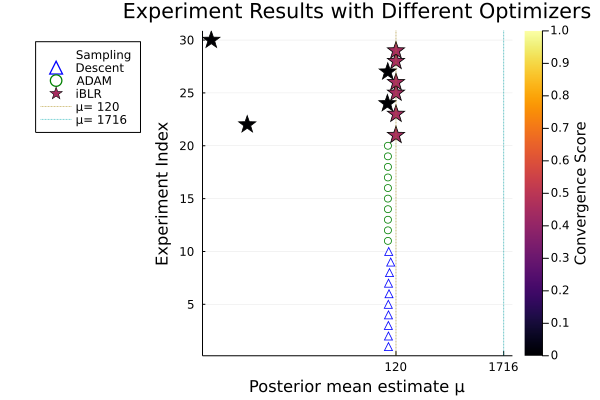

In [32]:
gr()
# Plot Sampling
data = [mean for (mean,algo) in zip(all_data[:mean],all_data[:algo]) if algo == 0]
idx = [idx for (idx,algo) in zip(all_data[:idx],all_data[:algo]) if algo == 0]
markershape =:rect
markercolor =:red
scatter(data,idx,markershape=markershape,m = (4, :white, stroke(1,markercolor)),label="Sampling")

# Plot Descent
data = [mean for (mean,algo) in zip(all_data[:mean],all_data[:algo]) if algo == 1]
idx = [idx for (idx,algo) in zip(all_data[:idx],all_data[:algo]) if algo == 1]
markershape =:utriangle
markercolor =:blue
scatter!(data,idx,markershape=markershape,m = (4, :white, stroke(1,markercolor)),label="Descent")

# Plot ADAM
data = [mean for (mean,algo) in zip(all_data[:mean],all_data[:algo]) if algo == 2]
idx = [idx for (idx,algo) in zip(all_data[:idx],all_data[:algo]) if algo == 2]
markershape =:circle
markercolor =:green
scatter!(data,idx,markershape=markershape,m = (4, :white, stroke(1,markercolor)),label="ADAM")

# Plot iBLR-3
data = [mean for (mean,algo) in zip(all_data[:mean],all_data[:algo]) if algo == 3]
idx = [idx for (idx,algo) in zip(all_data[:idx],all_data[:algo]) if algo == 3]
score = [score for (score,algo) in zip(all_data[:score],all_data[:algo]) if algo == 3]
markershape =:star5
markercolor =:match
my_colors = [cgrad(:inferno, [0.01, 0.99])[z] for z ∈ range(0.0, 1.0, length = 100)]
score[isnan.(score)].=100
colors_idx = Int64.(round.((exp.(-score.^2)*100)))
colors_idx[colors_idx .== 0].=1
colors_idx[colors_idx.>100] .= 100
colors = my_colors[colors_idx]
scatter!(data,idx,c= colors,markershape=markershape,markersize=9,label="iBLR",fillz=1,colorbar_title ="Convergence Score",legend=:outertopleft)

vline!([120],linestyle=:dot,label="μ= 120")
vline!([1716],linestyle=:dot,label="μ= 1716")
xlabel!("Posterior mean estimate μ")
ylabel!("Experiment Index")
xticks!([120,1716])
title!("Experiment Results with Different Optimizers")

#savefig("Presentation.pdf")

# Interactive Demonstration

Warning!, Convergence diagnostic indicator is = 1.0701710368384492
Adaptive method, mean of the posterior is = 120.00000193458213
---
Warning!, Convergence diagnostic indicator is = 1.0688831314745764
Adaptive method, mean of the posterior is = 120.00000849086611
---
Warning!, Convergence diagnostic indicator is = 1.0813526969989666
Adaptive method, mean of the posterior is = 120.00000352305624
---
Warning!, Convergence diagnostic indicator is = 1.0912467012835116
Adaptive method, mean of the posterior is = 120.00000433063231
---
Warning!, Convergence diagnostic indicator is = 1.0611193804746002
Adaptive method, mean of the posterior is = 120.00000136003668
---
Warning!, Convergence diagnostic indicator is = 1.0947265574857197
Adaptive method, mean of the posterior is = 120.00000496908953
---
Warning!, Convergence diagnostic indicator is = NaN
Adaptive method, mean of the posterior is = 0.03593616616305744
---
Warning!, Convergence diagnostic indicator is = 1.0685986011515376
Adaptive 

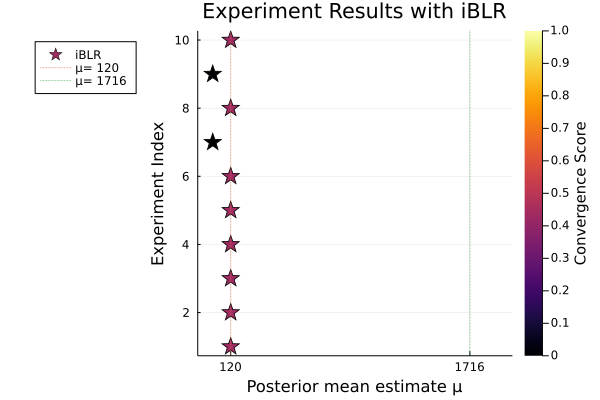

In [33]:
N = 10
interactive_data = Dict(:algo=>[],:idx=>[],:mean=>[],:score=>[])
interactive_idx_counter = 1
opt = iBLR(stepsize_update="adaptive",verbose=true)
#opt = iBLR(eta=5*1e-3,convergence_algo = "free_energy",verbose=true)
#opt = iBLR(eta=1e-8,convergence_algo = "none",verbose=true)


num_samples = 1000
g = FactorGraph()
@RV z ~ GaussianMeanVariance(0.0, 100.0)
@RV x ~ Cvi(z,g=f,opt=opt,num_samples=num_samples,num_iterations=Int64(1))
@RV y ~ GaussianMeanVariance(x, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(z)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs)
    marginals = step!(data,marginals)
    insert_data!(interactive_data,4,interactive_idx_counter,mean(marginals[:z]),opt.pareto_k_fit)
    interactive_idx_counter+=1
    println("Adaptive method, mean of the posterior is = $(mean(marginals[:z]))")
    println("---")
end


# Plot iBLR
data = interactive_data[:mean]
idx = interactive_data[:idx]
score = interactive_data[:score]
markershape =:star5
markercolor =:match

my_colors = [cgrad(:inferno, [0.01, 0.99])[z] for z ∈ range(0.0, 1.0, length = 100)]
score[isnan.(score)].=100
colors_idx = Int64.(round.((exp.(-score.^2)*100)))
colors_idx[colors_idx .== 0].=1
colors_idx[colors_idx.>100] .= 100
colors = my_colors[colors_idx]


scatter(data,idx,c= colors,markershape=markershape,markersize=9,label="iBLR",fillz=1,colorbar_title ="Convergence Score",legend=:outertopleft)
vline!([120],linestyle=:dot,label="μ= 120")
vline!([1716],linestyle=:dot,label="μ= 1716")
xlabel!("Posterior mean estimate μ")
ylabel!("Experiment Index")
xticks!([120,1716])
xlims!(-100,2000)
title!("Experiment Results with iBLR")